In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib as jbl
classified_df_filename='classified_df.csv'
new_classified_df_filename='new_classified_df.csv'
new_polarity_df_filename='new_polarity_df.csv'
model_filename='finalized_kmeans_jbl.sav'

In [3]:
new_polarity_df = pd.read_csv(new_polarity_df_filename)
new_classified_df = new_polarity_df.copy()

In [5]:
neg_results = new_classified_df[(new_classified_df['roberta_neg'] > (new_classified_df['roberta_pos'])) & (new_classified_df['roberta_neu'] < (new_classified_df['roberta_pos'] + new_classified_df['roberta_neg']))]
pos_results = new_classified_df[(new_classified_df['roberta_pos'] > (new_classified_df['roberta_neg'])) & (new_classified_df['roberta_neu'] < (new_classified_df['roberta_pos'] + new_classified_df['roberta_neg']))]
neu_results = new_classified_df[new_classified_df['roberta_neu'] > (new_classified_df['roberta_pos'] + new_classified_df['roberta_neg'])]

positive_index = pos_results.index
negative_index = neg_results.index
neutral_index = neu_results.index

new_classified_df['Sentiment'] = 2
new_classified_df['Sentiment'].iloc[positive_index] = 1
new_classified_df['Sentiment'].iloc[negative_index] = 0

C:\Users\tonch\AppData\Local\Temp\ipykernel_100356\2817585882.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_classified_df['Sentiment'].iloc[positive_index] = 1
C:\Users\tonch\AppData\Local\Temp\ipykernel_100356\2817585882.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_classified_df['Sentiment'].iloc[negative_index] = 0


In [6]:
new_classified_df.head()

,Text,Date,roberta_neg,roberta_neu,roberta_pos,Sentiment
0,ChatGPT is cool. But soon you'll be able to wr...,2023-02-04 01:28:43+00:00,0.005148,0.133562,0.861290,1
1,You have got to have the absolute worst self-c...,2023-02-04 01:28:37+00:00,0.969344,0.027905,0.002751,0
2,ChatGPT is the modern tech version of papal fo...,2023-02-04 01:28:35+00:00,0.279450,0.637331,0.083218,2
3,ChatGPT can probably churn out believable Link...,2023-02-04 01:28:35+00:00,0.258296,0.477726,0.263978,1
4,I was playing Genshin earlier and came upon th...,2023-02-04 01:28:27+00:00,0.565488,0.373092,0.061420,0


In [7]:
from sklearn.cluster import KMeans

In [8]:
x = new_classified_df.iloc[:,2:5].values
x = x.astype('float')

In [9]:
kmeans = jbl.load(model_filename)
y = kmeans.predict(x)
new_classified_df['cluster'] = y

In [10]:
new_classified_df.head()

,Text,Date,roberta_neg,roberta_neu,roberta_pos,Sentiment,cluster
0,ChatGPT is cool. But soon you'll be able to wr...,2023-02-04 01:28:43+00:00,0.005148,0.133562,0.861290,1,0
1,You have got to have the absolute worst self-c...,2023-02-04 01:28:37+00:00,0.969344,0.027905,0.002751,0,1
2,ChatGPT is the modern tech version of papal fo...,2023-02-04 01:28:35+00:00,0.279450,0.637331,0.083218,2,2
3,ChatGPT can probably churn out believable Link...,2023-02-04 01:28:35+00:00,0.258296,0.477726,0.263978,1,2
4,I was playing Genshin earlier and came upon th...,2023-02-04 01:28:27+00:00,0.565488,0.373092,0.061420,0,1


In [11]:
tweet_negative = new_classified_df[new_classified_df.cluster==0]
tweet_positive = new_classified_df[new_classified_df.cluster==1]
tweet_neutral = new_classified_df[new_classified_df.cluster==2]

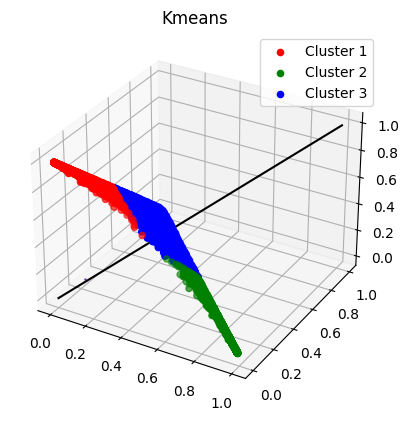

In [12]:
kplot = plt.axes(projection='3d')
xline = np.linspace(0, 1, 100)
yline = np.linspace(0, 1, 100)
zline = np.linspace(0, 1, 100)
kplot.plot3D(xline, yline, zline, 'black')

# Data for three-dimensional scattered points
kplot.scatter3D(tweet_negative.roberta_neg, tweet_negative.roberta_neu, tweet_negative.roberta_pos, c='red', label = 'Cluster 1')
kplot.scatter3D(tweet_positive.roberta_neg, tweet_positive.roberta_neu, tweet_positive.roberta_pos, c ='green', label = 'Cluster 2')
kplot.scatter3D(tweet_neutral.roberta_neg, tweet_neutral.roberta_neu, tweet_neutral.roberta_pos, c ='blue', label = 'Cluster 3')
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:,2], color = 'indigo')
plt.legend()
plt.title("Kmeans")
plt.show()

In [13]:
from sklearn.metrics import silhouette_score

score = silhouette_score(x, y)
print(score)

0.5940532074473007


In [14]:
from sklearn.metrics import confusion_matrix

manual_y = new_classified_df.iloc[:,5].values
kmeans_y = new_classified_df.iloc[:,6].values

In [15]:
confusion_matrix(manual_y, kmeans_y)

array([[   0, 2182,  320],
       [1569,    0,  147],
       [   0,    0, 2372]], dtype=int64)

In [16]:
index_to_replace_pos = new_classified_df[new_classified_df['cluster'] == 0].index
index_to_replace_neg = new_classified_df[new_classified_df['cluster'] == 1].index
new_classified_df['cluster'].iloc[index_to_replace_pos] = 1
new_classified_df['cluster'].iloc[index_to_replace_neg] = 0

new_classified_df.head()

C:\Users\tonch\AppData\Local\Temp\ipykernel_100356\552962747.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_classified_df['cluster'].iloc[index_to_replace_pos] = 1
C:\Users\tonch\AppData\Local\Temp\ipykernel_100356\552962747.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_classified_df['cluster'].iloc[index_to_replace_neg] = 0


,Text,Date,roberta_neg,roberta_neu,roberta_pos,Sentiment,cluster
0,ChatGPT is cool. But soon you'll be able to wr...,2023-02-04 01:28:43+00:00,0.005148,0.133562,0.861290,1,1
1,You have got to have the absolute worst self-c...,2023-02-04 01:28:37+00:00,0.969344,0.027905,0.002751,0,0
2,ChatGPT is the modern tech version of papal fo...,2023-02-04 01:28:35+00:00,0.279450,0.637331,0.083218,2,2
3,ChatGPT can probably churn out believable Link...,2023-02-04 01:28:35+00:00,0.258296,0.477726,0.263978,1,2
4,I was playing Genshin earlier and came upon th...,2023-02-04 01:28:27+00:00,0.565488,0.373092,0.061420,0,0


In [17]:
new_manual_y = new_classified_df.iloc[:,5].values
new_kmeans_y = new_classified_df.iloc[:,6].values

matrix = confusion_matrix(new_manual_y, new_kmeans_y)
len_diferences = matrix[0, 2] + matrix[1,2]
print(matrix)

[[2182    0  320]
 [   0 1569  147]
 [   0    0 2372]]


In [18]:
diferences = new_classified_df[(new_classified_df['Sentiment'] != 2) & (new_classified_df['cluster'] == 2)]
diferences.head()

,Text,Date,roberta_neg,roberta_neu,roberta_pos,Sentiment,cluster
3,ChatGPT can probably churn out believable Link...,2023-02-04 01:28:35+00:00,0.258296,0.477726,0.263978,1,2
7,Played with the chatgpt thing. It's fun to pla...,2023-02-04 01:28:19+00:00,0.292216,0.472149,0.235635,0,2
14,AI is the new self-driving. Always *just* a fe...,2023-02-04 01:26:15+00:00,0.082961,0.460502,0.456536,1,2
26,Imagine explaining to your grandparents the cu...,2023-02-04 01:23:21+00:00,0.437423,0.461478,0.101100,0,2
33,I wish I could have enjoyed AI Seinfeld before...,2023-02-04 01:21:10+00:00,0.258400,0.416069,0.325531,1,2


In [19]:
len(diferences) == len_diferences

True

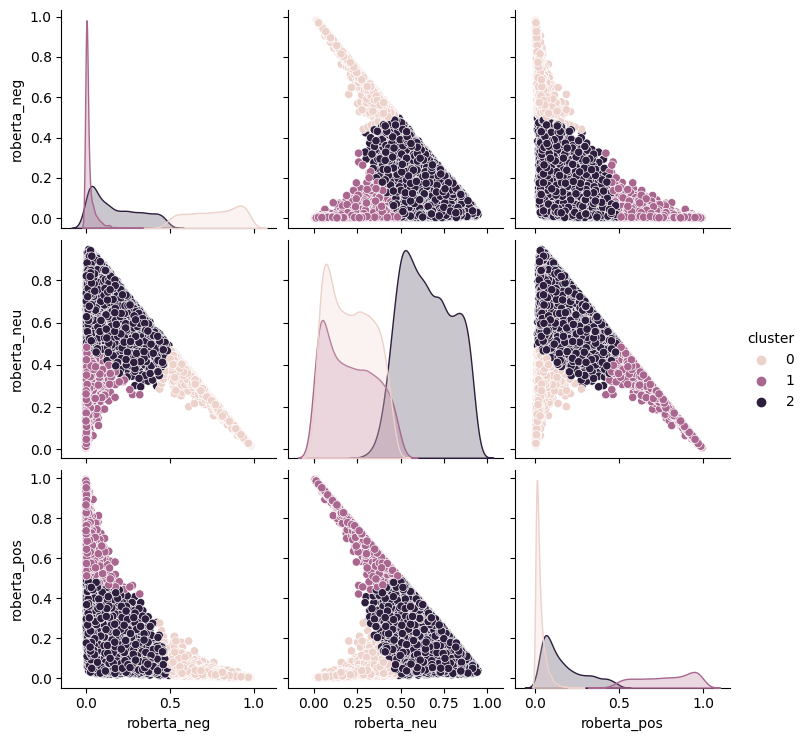

In [20]:
sns.pairplot(data=(new_classified_df.drop(['Sentiment'], axis=1)), vars=['roberta_neg', 'roberta_neu', 'roberta_pos'], hue='cluster')

In [21]:
n=3
print(diferences.iloc[n][['Sentiment', 'cluster']])
diferences.iloc[n].Text

Sentiment    0
cluster      2
Name: 26, dtype: object


'Imagine explaining to your grandparents the current issue that “ChatGPT turned out to be woke” 😂😂 If life ain’t a movie…'

In [ ]:
classified_df = pd.read_csv(classified_df_filename)
classified_df = pd.concat([classified_df, new_classified_df], ignore_index= True)
classified_df.drop_duplicates(subset=['Text'], ignore_index=True, inplace=True)
classified_df.head()

In [ ]:
classified_df.to_csv(classified_df_filename, index=False)
new_classified_df.to_csv(new_classified_df_filename, index=False)